In [9]:
# Importar la biblioteca pandas
import pandas as pd

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cambiar el directorio a la carpeta deseada
%cd /content/drive/MyDrive/Colab_Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks


In [ ]:
# Intentar leer el archivo CSV nuevamente

noc_region = pd.read_csv('noc_regions.csv')
# Imprimir los primeros 20 datos
# print(noc_region.head(20))

athletes = pd.read_csv('athlete_events.csv')
# Imprimir los primeros 20 datos
# print(athletes.head(20))

In [ ]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=5da63ba1db9871b0384b920a1852edbbb0a98b9cd7136cae0c2c0f3b17e1c0f6
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
pysqldf("SELECT * FROM athletes")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.merge(athletes, noc_region, how='left', left_on='NOC', right_on='NOC')

# Q1: Which countries or regions (NOC) have had better performance in specific sports over time?


In [11]:
# Asignar valores numéricos a cada tipo de medalla
medal_values = {'Gold': 3, 'Silver': 2, 'Bronze': 1}

# Agrupar por NOC, deporte y tipo de medalla, calcular el puntaje total
medal_score = data.groupby(['NOC', 'Sport', 'Medal'])['Medal'].count().reset_index(name='Count')
medal_score['Score'] = medal_score['Medal'].map(medal_values) * medal_score['Count']

# Calcular el puntaje total por tipo de medalla y NOC
medal_score_total = medal_score.groupby(['NOC', 'Sport'])['Score'].sum().reset_index()

# Identificar el NOC con el puntaje más alto por tipo de medalla y deporte
top_noc_per_sport_score = medal_score_total.loc[medal_score_total.groupby('Sport')['Score'].idxmax()]

# Ordenar los resultados por puntaje total por tipo de medalla
top_noc_per_sport_score = top_noc_per_sport_score.sort_values(by='Score', ascending=False)

# Eliminar la columna de índice
top_noc_per_sport_score.reset_index(drop=True, inplace=True)

print("Vista basada en puntajes:")
print(top_noc_per_sport_score)
#print("\n")


# Ahora, para la vista basada en el número de medallas por tipo de medalla:
# Pivotear los datos para obtener una columna por tipo de medalla
medal_count = medal_score.pivot_table(index=['NOC', 'Sport'], columns='Medal', values='Count', fill_value=0).reset_index()
medal_count = medal_count[['NOC', 'Sport', 'Gold', 'Silver', 'Bronze']]

# Ordenar los resultados por número de medallas de oro
medal_count = medal_count.sort_values(by='Gold', ascending=False)

# Eliminar la columna de índice
medal_count.reset_index(drop=True, inplace=True)

print("Vista basada en número de medallas por tipo:")
#print(medal_count.head())
medal_count

Vista basada en puntajes:
    NOC          Sport  Score
0   USA       Swimming   2630
1   USA      Athletics   2481
2   USA     Basketball    927
3   CAN     Ice Hockey    881
4   USA         Rowing    848
..  ...            ...    ...
61  GBR      Triathlon     10
62  USA          Roque      6
63  ESP  Basque Pelota      6
64  GBR   Jeu De Paume      3
65  SUI    Aeronautics      3

[66 rows x 3 columns]
Vista basada en número de medallas por tipo:


Medal,NOC,Sport,Gold,Silver,Bronze
0,USA,Swimming,649,254,175
1,USA,Athletics,542,317,221
2,USA,Basketball,281,24,36
3,CAN,Ice Hockey,220,93,35
4,USA,Rowing,186,101,88
...,...,...,...,...,...
1444,JPN,Fencing,0,5,0
1445,JPN,Football,0,18,16
1446,JPN,Hockey,0,11,0
1447,JPN,Sailing,0,2,2


# Q2: How has the participation of different countries and regions (NOC) in the Olympic Games evolved over the years, and how does their performance compare to each other?

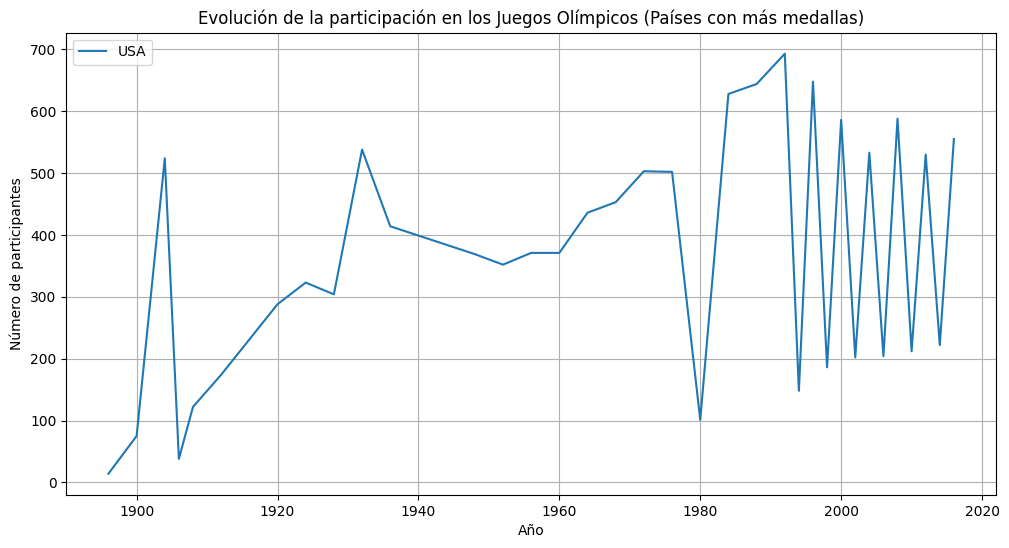

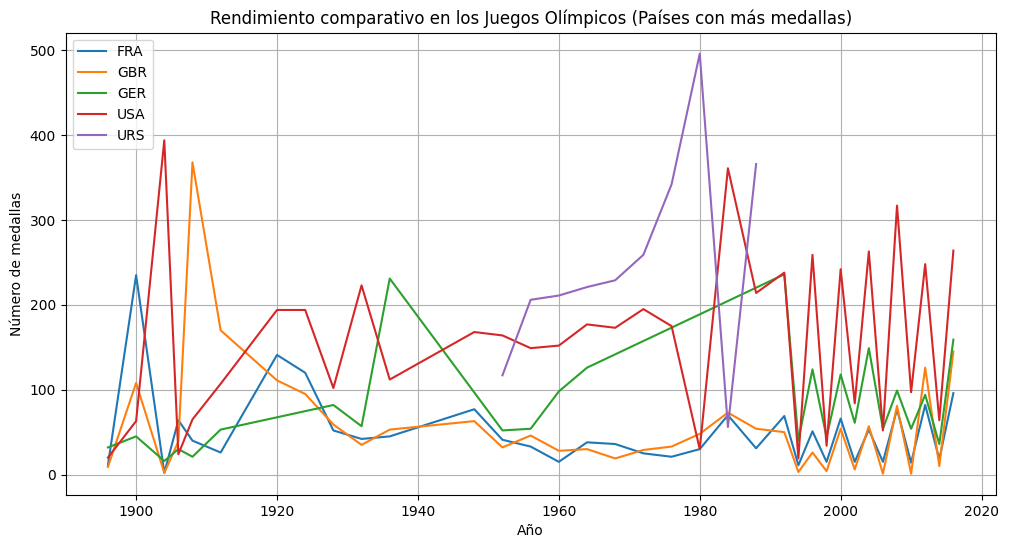

In [ ]:
# Análisis de la evolución de la participación
participation_evolution = data.groupby(['Year', 'region'])['ID'].nunique().reset_index()
participation_evolution.rename(columns={'ID': 'Participants'}, inplace=True)

# Análisis del rendimiento: Contar medallas por país, año y tipo de medalla
medal_recount = data.groupby(['Year', 'NOC', 'Medal'])['ID'].count().reset_index()

# Sumar medallas por país y año
medal_recount['Medal_Count'] = medal_recount.groupby(['Year', 'NOC'])['ID'].transform('sum')

# Seleccionar solo las filas con medallas
medal_recount = medal_recount[medal_recount['Medal'].notnull()]

# Eliminar duplicados y mantener solo una fila por país y año
medal_recount = medal_recount.drop_duplicates(subset=['Year', 'NOC'])

# Obtener la información de continente de cada NOC
noc_continent = noc_region[['NOC', 'region']].drop_duplicates()

# Unir los datos de medallas con la información de continente
medal_recount = pd.merge(medal_recount, noc_continent, how='left', on='NOC')

# Seleccionar los países o regiones con el mayor número total de medallas
top_countries = medal_recount.groupby('NOC')['Medal_Count'].sum().nlargest(5).index.tolist()

# Filtrar los datos para incluir solo los países seleccionados
participation_evolution_filtered = participation_evolution[participation_evolution['region'].isin(top_countries)]
medal_count_filtered = medal_recount[medal_recount['NOC'].isin(top_countries)]

# Graficar la evolución de la participación
plt.figure(figsize=(12, 6))
for region in participation_evolution_filtered['region'].unique():
    plt.plot(participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Year'],
             participation_evolution_filtered[participation_evolution_filtered['region'] == region]['Participants'],
             label=region)
plt.title('Evolución de la participación en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de participantes')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Graficar el rendimiento comparativo
plt.figure(figsize=(12, 6))
for noc in medal_count_filtered['NOC'].unique():
    plt.plot(medal_count_filtered[medal_count_filtered['NOC'] == noc]['Year'],
             medal_count_filtered[medal_count_filtered['NOC'] == noc]['Medal_Count'],
             label=noc)
plt.title('Rendimiento comparativo en los Juegos Olímpicos (Países con más medallas)')
plt.xlabel('Año')
plt.ylabel('Número de medallas')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


Seleccione una opción:
1. Ver historial total por país.
2. Filtrar por país y deporte.
Ingrese el número de la opción que desee: 1
Ingrese el código del país (NOC) para ver su rendimiento a lo largo de los años: PER


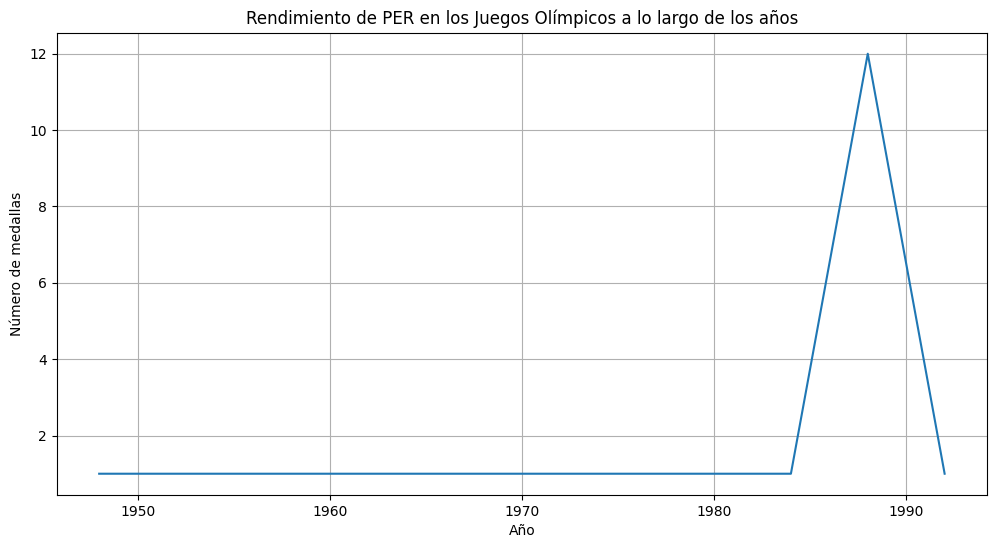

In [ ]:
# Menú principal
print("Seleccione una opción:")
print("1. Ver historial total por país.")
print("2. Filtrar por país y deporte.")
option = input("Ingrese el número de la opción que desee: ")

if option == '1':
    # Opción de buscar el rendimiento a lo largo de los años de un país
    country_input = input("Ingrese el código del país (NOC) para ver su rendimiento a lo largo de los años: ")
    if country_input in medal_recount['NOC'].unique():
        country_data = medal_recount[medal_recount['NOC'] == country_input]
        if not country_data.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(country_data['Year'], country_data['Medal_Count'])
            plt.title(f'Rendimiento de {country_input} en los Juegos Olímpicos a lo largo de los años')
            plt.xlabel('Año')
            plt.ylabel('Número de medallas')
            plt.grid(True)
            plt.show()
        else:
            print("No hay datos de medallas para este país en la base de datos.")
    else:
        print("El país ingresado no se encuentra en la base de datos.")

elif option == '2':
    # Opción de filtrar por país y deporte
    country_input = input("Ingrese el código del país (NOC): ")
    sport_input = input("Ingrese el deporte: ")
    if country_input in medal_recount['NOC'].unique() and sport_input in data['Sport'].unique():
        country_sport_data = data[(data['NOC'] == country_input) & (data['Sport'] == sport_input)]
        if not country_sport_data.empty:
            # Revisamos si hay medallas antes de trazar el gráfico
            if 'Year' in country_sport_data.columns:
                gold_data = country_sport_data[country_sport_data['Medal'] == 'Gold'].groupby('Year')['ID'].count()
                silver_data = country_sport_data[country_sport_data['Medal'] == 'Silver'].groupby('Year')['ID'].count()
                bronze_data = country_sport_data[country_sport_data['Medal'] == 'Bronze'].groupby('Year')['ID'].count()

                # Combinamos las series de datos en un DataFrame
                medal_count_country_sport = pd.DataFrame({'Gold': gold_data, 'Silver': silver_data, 'Bronze': bronze_data}).reset_index()

                plt.figure(figsize=(12, 6))
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Gold'], label='Gold')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Silver'], label='Silver')
                plt.plot(medal_count_country_sport['Year'], medal_count_country_sport['Bronze'], label='Bronze')
                plt.title(f'Rendimiento de {country_input} en {sport_input} a lo largo de los años')
                plt.xlabel('Año')
                plt.ylabel('Número de medallas')
                plt.legend(loc='upper left')
                plt.grid(True)
                plt.show()
            else:
                print("No hay datos de medallas para este país y deporte en la base de datos.")
        else:
            print("No hay datos de medallas para este país y deporte en la base de datos.")
    else:
        print("Los datos ingresados no se encuentran en la base de datos.")

else:
    print("Opción no válida.")


# Q3: Are there patterns or trends in athletes’ performance related to factors such as age, height, and weight?



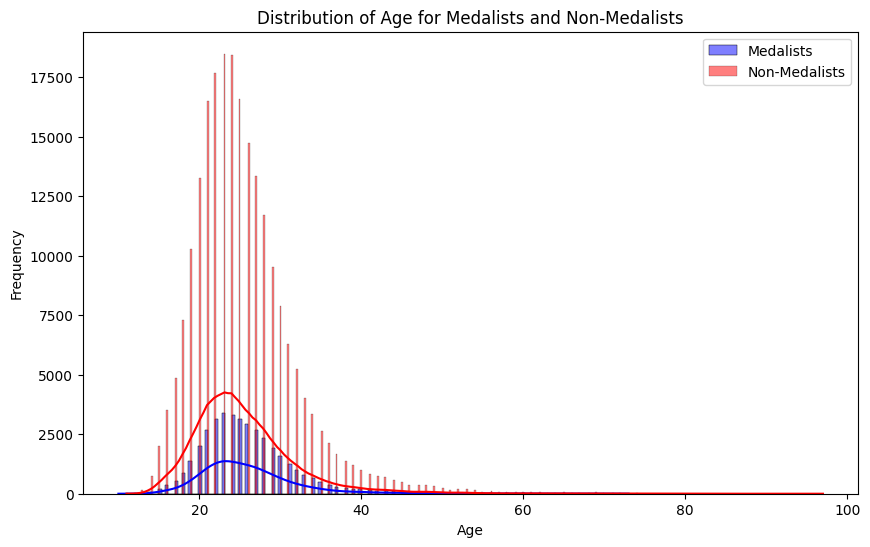

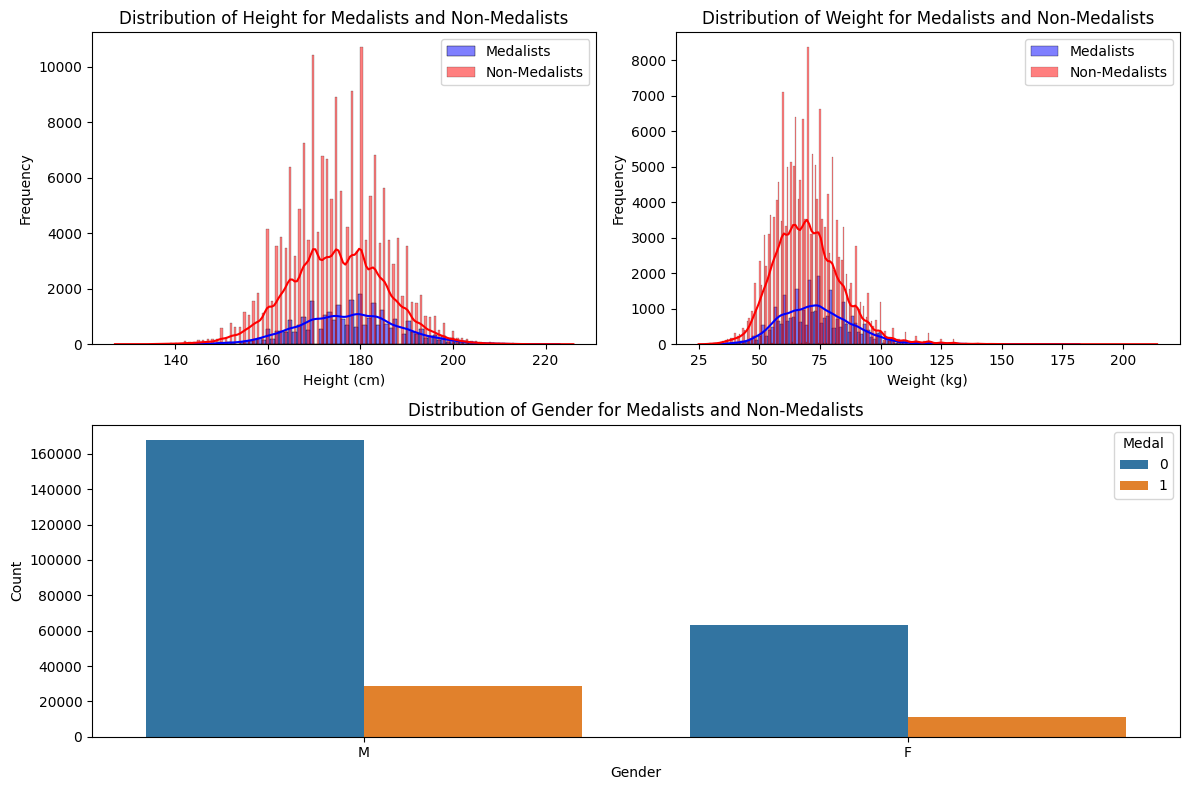

In [ ]:
# Filtrar los datos para atletas que ganaron medallas y los que no
medalists = data[data['Medal'] == 1]
non_medalists = data[data['Medal'] == 0]

# Visualizar la distribución de la edad para los atletas que ganaron medallas y los que no
plt.figure(figsize=(10, 6))
sns.histplot(data=medalists, x='Age', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Age', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Age for Medalists and Non-Medalists')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Visualizar la distribución de la altura para los atletas que ganaron medallas y los que no
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(data=medalists, x='Height', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Height', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Height for Medalists and Non-Medalists')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.legend()

# Visualizar la distribución del peso para los atletas que ganaron medallas y los que no
plt.subplot(2, 2, 2)
sns.histplot(data=medalists, x='Weight', kde=True, color='blue', label='Medalists', alpha=0.5)
sns.histplot(data=non_medalists, x='Weight', kde=True, color='red', label='Non-Medalists', alpha=0.5)
plt.title('Distribution of Weight for Medalists and Non-Medalists')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.legend()

# Visualizar la distribución del género para los atletas que ganaron medallas y los que no
plt.subplot(2, 1, 2)
sns.countplot(data=data, x='Sex', hue='Medal')
plt.title('Distribution of Gender for Medalists and Non-Medalists')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Medal', loc='upper right')

plt.tight_layout()
plt.show()


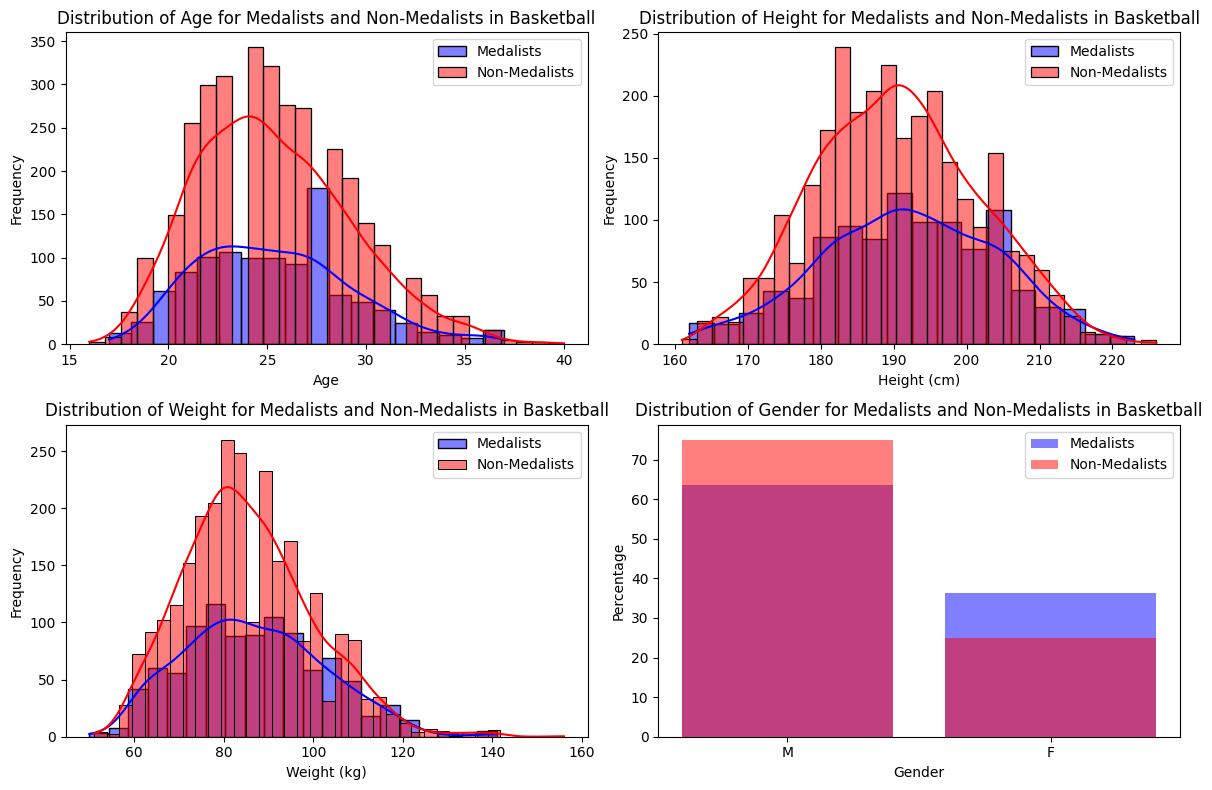

In [ ]:

def analyze_sport_performance(data, sport):
    # Filtrar los datos para el deporte especificado
    sport_data = data[data['Sport'] == sport]

    # Filtrar los datos para atletas que ganaron medallas y los que no en el deporte especificado
    medalists = sport_data[sport_data['Medal'] == 1]
    non_medalists = sport_data[sport_data['Medal'] == 0]

    # Visualizar la distribución de la edad para los atletas que ganaron medallas y los que no
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.histplot(data=medalists, x='Age', kde=True, color='blue', label='Medalists', alpha=0.5)
    sns.histplot(data=non_medalists, x='Age', kde=True, color='red', label='Non-Medalists', alpha=0.5)
    plt.title(f'Distribution of Age for Medalists and Non-Medalists in {sport}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()

    # Visualizar la distribución de la altura para los atletas que ganaron medallas y los que no
    plt.subplot(2, 2, 2)
    sns.histplot(data=medalists, x='Height', kde=True, color='blue', label='Medalists', alpha=0.5)
    sns.histplot(data=non_medalists, x='Height', kde=True, color='red', label='Non-Medalists', alpha=0.5)
    plt.title(f'Distribution of Height for Medalists and Non-Medalists in {sport}')
    plt.xlabel('Height (cm)')
    plt.ylabel('Frequency')
    plt.legend()

    # Visualizar la distribución del peso para los atletas que ganaron medallas y los que no
    plt.subplot(2, 2, 3)
    sns.histplot(data=medalists, x='Weight', kde=True, color='blue', label='Medalists', alpha=0.5)
    sns.histplot(data=non_medalists, x='Weight', kde=True, color='red', label='Non-Medalists', alpha=0.5)
    plt.title(f'Distribution of Weight for Medalists and Non-Medalists in {sport}')
    plt.xlabel('Weight (kg)')
    plt.ylabel('Frequency')
    plt.legend()

    # Calcular los porcentajes de género para los atletas que ganaron medallas y los que no
    gender_percentage_medalists = medalists['Sex'].value_counts(normalize=True) * 100
    gender_percentage_non_medalists = non_medalists['Sex'].value_counts(normalize=True) * 100

    # Visualizar la distribución del género para los atletas que ganaron medallas y los que no
    plt.subplot(2, 2, 4)
    plt.bar(gender_percentage_medalists.index, gender_percentage_medalists, color='blue', label='Medalists', alpha=0.5)
    plt.bar(gender_percentage_non_medalists.index, gender_percentage_non_medalists, color='red', label='Non-Medalists', alpha=0.5)
    plt.title(f'Distribution of Gender for Medalists and Non-Medalists in {sport}')
    plt.xlabel('Gender')
    plt.ylabel('Percentage')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejemplo de análisis por deporte (baloncesto)
analyze_sport_performance(data, 'Basketball')